# Cluster de clientes

Tem como objetivo...

In [1]:
import numpy as np 
import pandas as pd
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import pickle

sns.set_style('whitegrid', {"axes.grid" : False})
sns.set_context('notebook')
np.random.seed(42)

pd.set_option('display.max_columns', None)

Segue abaixo uma visualizacao dos dados que serao utilizadas no treinamento do modelo e na avaliacao.

In [2]:
def limpezaParaTreino(df, arrayColDrop):
  df_proc = df.drop(arrayColDrop, axis=1)
  df_proc = pd.get_dummies(df_proc)
  return df_proc

In [3]:
tipo_prod = pd.read_csv("../repository/tipo_prod_group.csv",sep=';')
usu_prod = pd.read_csv("../repository/usu_prod_group.csv",sep=',')

tipo_de_produto_do_cliente = pd.merge(usu_prod, tipo_prod, on='ProdutoId')
tipo_de_produto_do_cliente.TipoCarteira__c.fillna(tipo_de_produto_do_cliente.NomeInvestimento__c, inplace=True)
tipo_de_produto_do_cliente = tipo_de_produto_do_cliente.drop(['NomeInvestimento__c', 'ProdutoId'], axis=1)
tipo_de_produto_do_cliente

,Id,TipoCarteira__c
0,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe9yBilu2JVQh2nFTHN...,Fundo de Renda Fixa
1,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,Fundo de Renda Fixa
2,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,Fundo de Renda Fixa
3,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,Fundo de Renda Fixa
4,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,Fundo de Renda Fixa
...,...,...
36478,$2b$10$.DCvvJ9WSDpqVP2xXjeSPesRqwgEsVh8ifWr5Jb...,LCI
36479,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeLsP5rKvCpi7yLFS/P...,Fundo Multimercado
36480,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe56H4FnPI1ZjIb.l.O...,CDB
36481,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeNMSbvxsUZD/GBI/Fo...,CDB


In [4]:
clientes = pd.read_csv("../repository/clientes.csv",sep=';')
clientes

,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,Ind_Guardado,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,Soma_Investido_Total
0,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..Fx6NhsrK9ZzYadq...,35,C,Juiz de Fora,1,1,2,2000,15000,1,2,2,1,60
1,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..kI2Jy5NBFp0bWHG...,22,S,São Paulo,0,0,0,1900,1000,0,0,0,0,0
2,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./h2nCG51DS8AEwV8...,51,C,Santos,5,5,4,8000,300000,2,3,3,3,0
3,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./np28dLDLl04GG7s...,36,S,Jundiaí,5,5,5,15000,450000,3,4,5,3,5000
4,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./RaD5ilKiZI.7Hik...,34,S,Brasília,1,1,3,1380,0,3,3,4,2,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13403,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeZzlfpdbYbWbiMI2O2...,41,S,Guarulhos,1,1,2,4000,0,1,2,3,1,60
13404,$2b$10$.DCvvJ9WSDpqVP2xXjeSPezZnFnre0ofPq1wRF1...,30,C,São Paulo,4,4,4,16000,40000,3,4,3,3,31500
13405,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeZzP5DRGfb11bMIrV8...,44,S,São Paulo,1,1,1,0,100000,1,1,1,1,"104,44"
13406,$2b$10$.DCvvJ9WSDpqVP2xXjeSPezzttIBRwey7HP2/F/...,31,C,Campo Grande,0,5,4,5500,85000,2,3,5,3,"1030,65"


In [5]:
clientes['Soma_Investido_Total']= pd.to_numeric(clientes['Soma_Investido_Total'].str.replace(',','.'))
clientes['ValorPatrimonio']     = pd.to_numeric(clientes['ValorPatrimonio'].str.replace(',','.'))
clientes['RendaMensal']         = pd.to_numeric(clientes['RendaMensal'].str.replace(',','.'))
clientes['Sao_Paulo']           = clientes['BillingCity'] == 'São Paulo'
clientes['Rio']                 = clientes['BillingCity'] == 'Rio de Janeiro'
clientes['Brasilia']            = clientes['BillingCity'] == 'Brasília'

clientes = pd.merge(clientes, tipo_de_produto_do_cliente, how='left', on='Id')

scaler = StandardScaler()
clientes['Soma_Investido_Total_Scaler'] = 0
clientes['ValorPatrimonio_Scaler'] = 0
clientes['RendaMensal_Scaler'] = 0
clientes[['Soma_Investido_Total_Scaler', 'ValorPatrimonio_Scaler', 'RendaMensal_Scaler']] = scaler.fit_transform(clientes[['Soma_Investido_Total', 'ValorPatrimonio', 'RendaMensal']])

clientes_proc = limpezaParaTreino(clientes, ['Id', 'BillingCity', 'Soma_Investido_Total', 'ValorPatrimonio', 'RendaMensal'])
clientes_proc

,Idade,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,Ind_Guardado,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,Sao_Paulo,Rio,Brasilia,Soma_Investido_Total_Scaler,ValorPatrimonio_Scaler,RendaMensal_Scaler,EstadoCivil_C,EstadoCivil_D,EstadoCivil_I,EstadoCivil_M,EstadoCivil_S,EstadoCivil_V,TipoCarteira__c_CDB,TipoCarteira__c_Catálogo Padrão Tesouro Direto,TipoCarteira__c_FIC de Fundo Cambial,TipoCarteira__c_FIC de Fundo Multimercado,TipoCarteira__c_FIC de Fundo de Ações,TipoCarteira__c_FIC de Fundo de Renda Fixa,TipoCarteira__c_Fundo Cambial,TipoCarteira__c_Fundo Multimercado,TipoCarteira__c_Fundo de Ações,TipoCarteira__c_Fundo de Renda Fixa,TipoCarteira__c_LC,TipoCarteira__c_LCA,TipoCarteira__c_LCI
0,35,1,1,2,1,2,2,1,False,False,False,-0.301878,-0.048718,-0.231369,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,35,1,1,2,1,2,2,1,False,False,False,-0.301878,-0.048718,-0.231369,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,22,0,0,0,0,0,0,0,True,False,False,-0.302398,-0.049854,-0.234992,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,51,5,5,4,2,3,3,3,False,False,False,-0.302398,-0.025604,-0.013966,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,36,5,5,5,3,4,5,3,False,False,False,-0.259074,-0.013438,0.239671,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37922,30,4,4,4,3,4,3,3,True,False,False,-0.029458,-0.046691,0.275905,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
37923,44,1,1,1,1,1,1,1,True,False,False,-0.301493,-0.041824,-0.303837,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
37924,31,0,5,4,2,3,5,3,False,False,False,-0.293468,-0.043041,-0.104551,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
37925,31,0,5,4,2,3,5,3,False,False,False,-0.293468,-0.043041,-0.104551,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Analise com 5 cluster

In [6]:
Kmean = KMeans(n_clusters=5)
Kmean.fit(clientes_proc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
dfL = pd.DataFrame({'label': Kmean.labels_})
result = pd.concat([clientes, dfL], axis=1, join='inner')
result = result.drop(['Id', 'BillingCity'], axis=1)

In [8]:
result.groupby(['label'])['Idade'].count()

label
0     8715
1     5355
2    11552
3     2340
4     9965
Name: Idade, dtype: int64

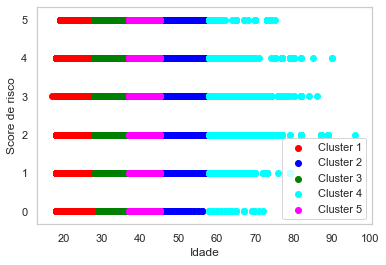

In [9]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ScoreRisco, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

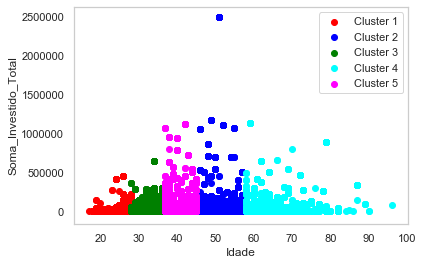

In [10]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Soma_Investido_Total')
plt.legend()
plt.show()

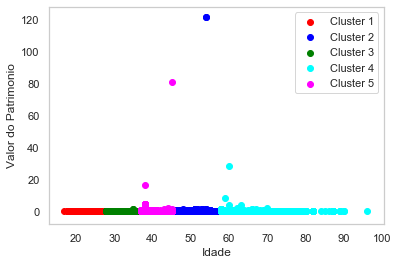

In [11]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio_Scaler, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

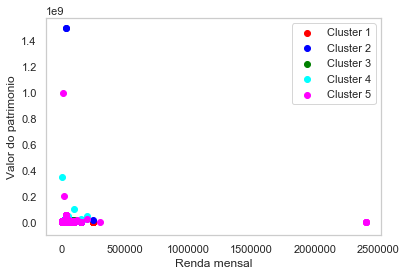

In [12]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

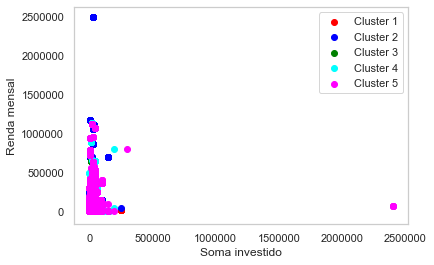

In [13]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Soma investido')
plt.ylabel('Renda mensal')
plt.legend()
plt.show()

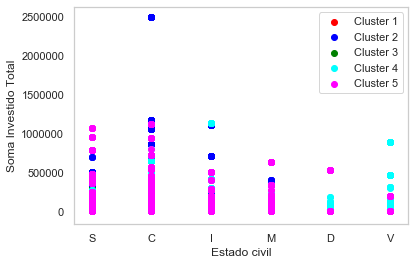

In [14]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].EstadoCivil, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Estado civil')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

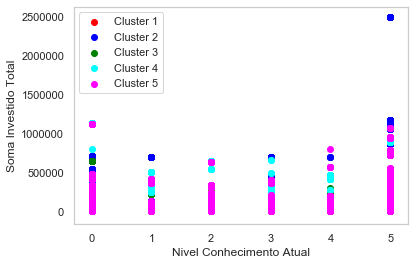

In [15]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].NivelConhecimentoAtual, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

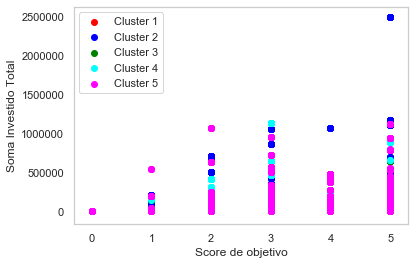

In [16]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].ScoreObjetivos, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Score de objetivo')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

### Analise com 7 cluster

In [17]:
Kmean = KMeans(n_clusters=7)
Kmean.fit(clientes_proc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
dfL = pd.DataFrame({'label': Kmean.labels_})
result = pd.concat([clientes, dfL], axis=1, join='inner')
result = result.drop(['Id', 'BillingCity'], axis=1)

In [19]:
result.groupby(['label'])['Idade'].count()

label
0    1628
1    4512
2    6505
3    3772
4    6426
5    6410
6    8674
Name: Idade, dtype: int64

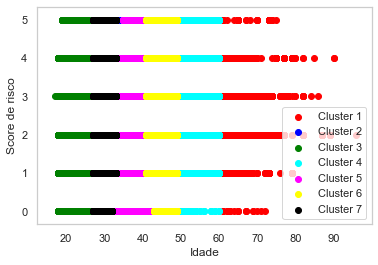

In [20]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ScoreRisco, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ScoreRisco, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ScoreRisco, c = 'black', label = 'Cluster 7')

plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

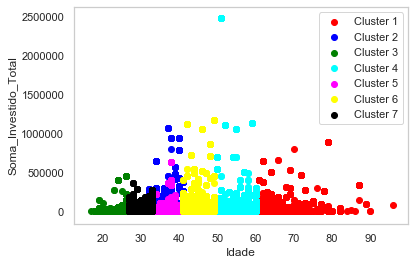

In [21]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].Soma_Investido_Total, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].Soma_Investido_Total, c = 'black', label = 'Cluster 7')
plt.xlabel('Idade')
plt.ylabel('Soma_Investido_Total')
plt.legend()
plt.show()

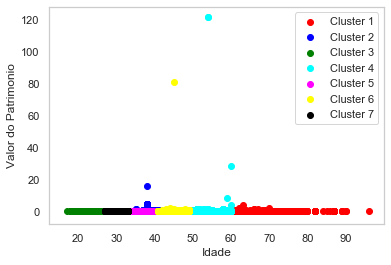

In [22]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio_Scaler, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ValorPatrimonio_Scaler, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ValorPatrimonio_Scaler, c = 'black', label = 'Cluster 7')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

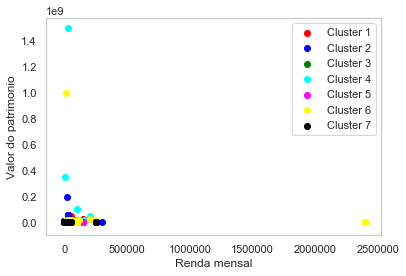

In [23]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].RendaMensal, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].RendaMensal, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

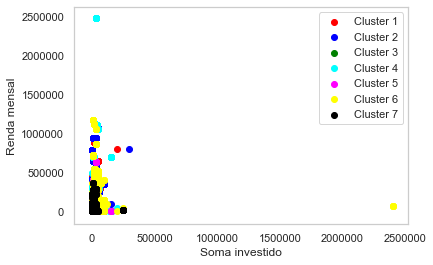

In [24]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].RendaMensal, result[result['label'] == 5].Soma_Investido_Total, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].RendaMensal, result[result['label'] == 6].Soma_Investido_Total, c = 'black', label = 'Cluster 7')
plt.xlabel('Soma investido')
plt.ylabel('Renda mensal')
plt.legend()
plt.show()

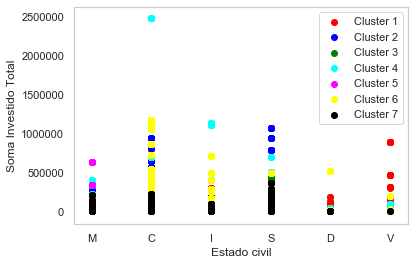

In [25]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].EstadoCivil, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].EstadoCivil, result[result['label'] == 5].Soma_Investido_Total, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].EstadoCivil, result[result['label'] == 6].Soma_Investido_Total, c = 'black', label = 'Cluster 7')
plt.xlabel('Estado civil')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

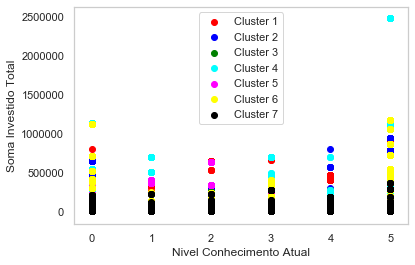

In [26]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].NivelConhecimentoAtual, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].NivelConhecimentoAtual, result[result['label'] == 5].Soma_Investido_Total, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].NivelConhecimentoAtual, result[result['label'] == 6].Soma_Investido_Total, c = 'black', label = 'Cluster 7')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

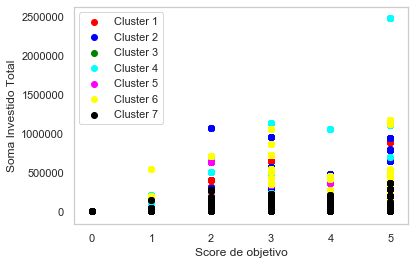

In [27]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].Soma_Investido_Total, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].Soma_Investido_Total, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].Soma_Investido_Total, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].Soma_Investido_Total, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].ScoreObjetivos, result[result['label'] == 4].Soma_Investido_Total, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].ScoreObjetivos, result[result['label'] == 5].Soma_Investido_Total, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].ScoreObjetivos, result[result['label'] == 6].Soma_Investido_Total, c = 'black', label = 'Cluster 7')
plt.xlabel('Score de objetivo')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

## Separacao dos clientes

In [28]:
clientes_com_investimento = clientes[clientes['Soma_Investido_Total']>0]
clientes_sem_investimento = clientes[clientes['Soma_Investido_Total']==0]

In [29]:
clientes_com_investimento

,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,Ind_Guardado,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,Soma_Investido_Total,Sao_Paulo,Rio,Brasilia,TipoCarteira__c,Soma_Investido_Total_Scaler,ValorPatrimonio_Scaler,RendaMensal_Scaler
0,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..Fx6NhsrK9ZzYadq...,35,C,Juiz de Fora,1,1,2,2000.0,15000.0,1,2,2,1,60.00,False,False,False,Fundo de Renda Fixa,-0.301878,-0.048718,-0.231369
1,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..Fx6NhsrK9ZzYadq...,35,C,Juiz de Fora,1,1,2,2000.0,15000.0,1,2,2,1,60.00,False,False,False,Fundo Multimercado,-0.301878,-0.048718,-0.231369
4,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./np28dLDLl04GG7s...,36,S,Jundiaí,5,5,5,15000.0,450000.0,3,4,5,3,5000.00,False,False,False,Fundo Multimercado,-0.259074,-0.013438,0.239671
5,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./RaD5ilKiZI.7Hik...,34,S,Brasília,1,1,3,1380.0,0.0,3,3,4,2,30.00,False,False,True,Fundo Multimercado,-0.302138,-0.049935,-0.253834
7,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./VfMzqzrDosESSEW...,57,C,Maringá,1,1,1,1950.0,300000.0,1,1,2,1,125.50,False,False,False,Fundo de Renda Fixa,-0.301311,-0.025604,-0.233181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37921,$2b$10$.DCvvJ9WSDpqVP2xXjeSPezZnFnre0ofPq1wRF1...,30,C,São Paulo,4,4,4,16000.0,40000.0,3,4,3,3,31500.00,True,False,False,Fundo de Ações,-0.029458,-0.046691,0.275905
37922,$2b$10$.DCvvJ9WSDpqVP2xXjeSPezZnFnre0ofPq1wRF1...,30,C,São Paulo,4,4,4,16000.0,40000.0,3,4,3,3,31500.00,True,False,False,Fundo de Ações,-0.029458,-0.046691,0.275905
37923,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeZzP5DRGfb11bMIrV8...,44,S,São Paulo,1,1,1,0.0,100000.0,1,1,1,1,104.44,True,False,False,Catálogo Padrão Tesouro Direto,-0.301493,-0.041824,-0.303837
37924,$2b$10$.DCvvJ9WSDpqVP2xXjeSPezzttIBRwey7HP2/F/...,31,C,Campo Grande,0,5,4,5500.0,85000.0,2,3,5,3,1030.65,False,False,False,Fundo Multimercado,-0.293468,-0.043041,-0.104551


In [30]:
clientes_sem_investimento

,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,Ind_Guardado,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,Soma_Investido_Total,Sao_Paulo,Rio,Brasilia,TipoCarteira__c,Soma_Investido_Total_Scaler,ValorPatrimonio_Scaler,RendaMensal_Scaler
2,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..kI2Jy5NBFp0bWHG...,22,S,São Paulo,0,0,0,1900.0,1000.0,0,0,0,0,0.0,True,False,False,NaN,-0.302398,-0.049854,-0.234992
3,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./h2nCG51DS8AEwV8...,51,C,Santos,5,5,4,8000.0,300000.0,2,3,3,3,0.0,False,False,False,NaN,-0.302398,-0.025604,-0.013966
6,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./u5K4501CL/f68At...,31,C,Goiânia,1,1,2,2000.0,0.0,1,2,4,1,0.0,False,False,False,NaN,-0.302398,-0.049935,-0.231369
12,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe.0LFWjhy7h5dIlyeK...,24,C,Santo André,1,1,2,1000.0,0.0,3,2,2,2,0.0,False,False,False,NaN,-0.302398,-0.049935,-0.267603
13,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe.0TyIuDbXgsobnH1w...,43,D,Rio Negro,0,0,0,10000.0,900000.0,0,0,0,0,0.0,False,False,False,NaN,-0.302398,0.023058,0.058502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37827,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeZWbvlwbOZEegHxerT...,34,C,Paulista,1,1,2,1800.0,0.0,1,2,2,1,0.0,False,False,False,NaN,-0.302398,-0.049935,-0.238616
37845,$2b$10$.DCvvJ9WSDpqVP2xXjeSPezXGgZOmJZKOakWPhd...,26,S,Chapecó,2,2,3,2850.0,26.0,1,3,5,1,0.0,False,False,False,NaN,-0.302398,-0.049933,-0.200570
37882,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeZyNw/sWcwO7AhFBkT...,48,C,Cuiabá,2,2,2,5000.0,60000.0,1,2,3,2,0.0,False,False,False,NaN,-0.302398,-0.045069,-0.122667
37895,$2b$10$.DCvvJ9WSDpqVP2xXjeSPezzcMs1mEQlySS8KUO...,40,S,Aracaju,1,1,1,5800.0,0.0,1,2,1,1,0.0,False,False,False,NaN,-0.302398,-0.049935,-0.093680


In [31]:
cli_train = limpezaParaTreino(clientes_com_investimento, ['Id', 'BillingCity', 'Soma_Investido_Total', 'ValorPatrimonio', 'RendaMensal', 'Soma_Investido_Total_Scaler'])

### Analise com 4 cluster

In [32]:
Kmean = KMeans(n_clusters=4)
Kmean.fit(cli_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### Dados de treino - clientes com investimentos

In [33]:
dfL = pd.DataFrame({'label': Kmean.labels_}, index=clientes_com_investimento.index)
result = pd.concat([clientes_com_investimento, dfL], axis=1, join='inner')

In [34]:
result.groupby(['label'])['Idade'].count()

label
0    14449
1     7672
2     3257
3    10966
Name: Idade, dtype: int64

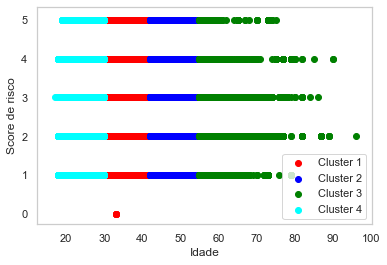

In [35]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

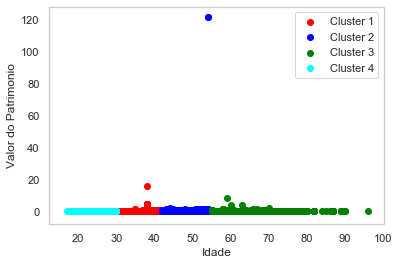

In [36]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

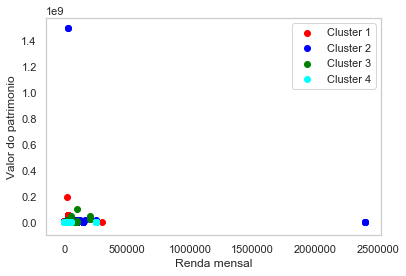

In [37]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

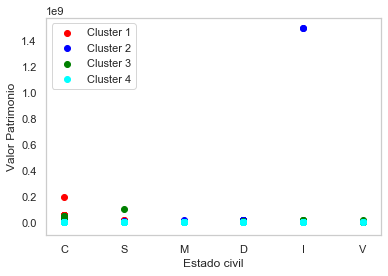

In [38]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Estado civil')
plt.ylabel('Valor Patrimonio')
plt.legend()
plt.show()

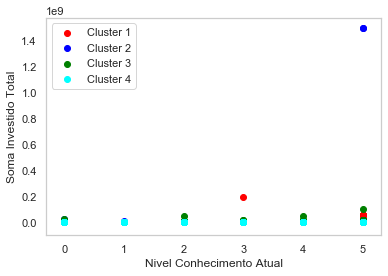

In [39]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

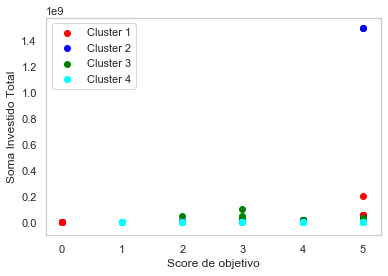

In [40]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Score de objetivo')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

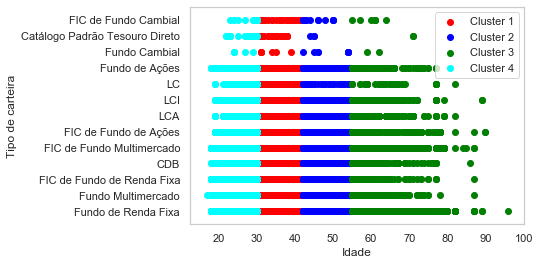

In [41]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].TipoCarteira__c, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].TipoCarteira__c, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].TipoCarteira__c, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].TipoCarteira__c, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Idade')
plt.ylabel('Tipo de carteira')
plt.legend()
plt.show()

#### Predicao para clientes sem investimentos

In [42]:
cli_test = limpezaParaTreino(clientes_sem_investimento, ['Id', 'BillingCity', 'Soma_Investido_Total', 'ValorPatrimonio', 'RendaMensal', 'Soma_Investido_Total_Scaler'])

for coluna in cli_train.columns:
  if coluna.startswith('TipoCarteira__c'):
    cli_test[coluna] = 0

In [43]:
labelsTest = Kmean.predict(cli_test)

dfL = pd.DataFrame({'label': labelsTest},
                    index=clientes_sem_investimento.index)
result = pd.concat([clientes_sem_investimento, dfL], axis=1, join='inner')

In [44]:
result.groupby(['label'])['Idade'].count()

label
0    559
1    337
2     98
3    589
Name: Idade, dtype: int64

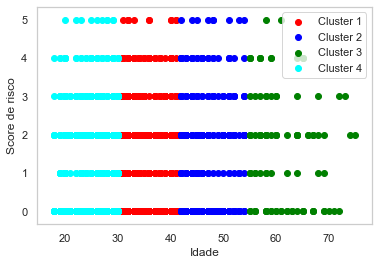

In [45]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

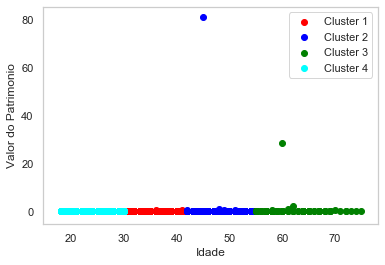

In [46]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

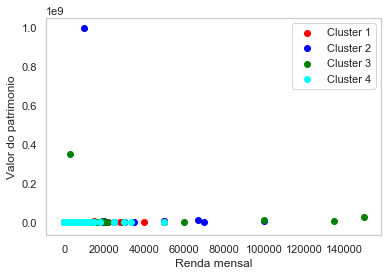

In [47]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

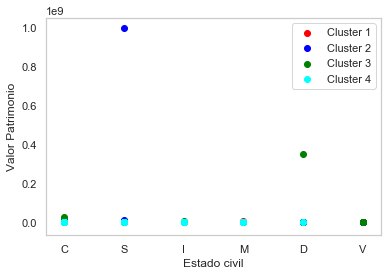

In [48]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Estado civil')
plt.ylabel('Valor Patrimonio')
plt.legend()
plt.show()

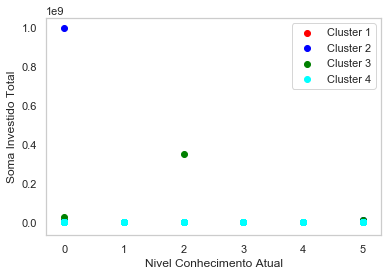

In [49]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

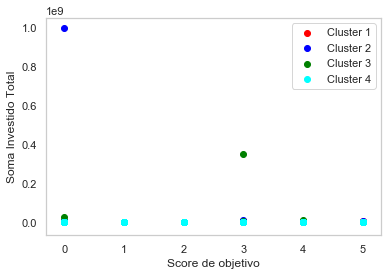

In [50]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.xlabel('Score de objetivo')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

### Analise com 5 cluster

In [51]:
Kmean = KMeans(n_clusters=5)
Kmean.fit(cli_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### Dados de treino - clientes com investimentos

In [52]:
dfL = pd.DataFrame({'label': Kmean.labels_}, index=clientes_com_investimento.index)
result = pd.concat([clientes_com_investimento, dfL], axis=1, join='inner')

In [53]:
result.groupby(['label'])['Idade'].count()

label
0     9201
1     4803
2     2035
3    11564
4     8741
Name: Idade, dtype: int64

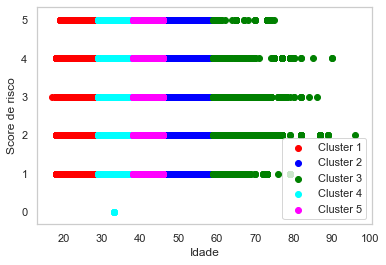

In [54]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ScoreRisco, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

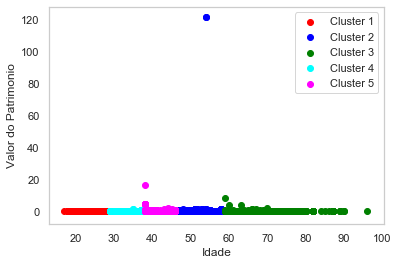

In [55]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio_Scaler, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

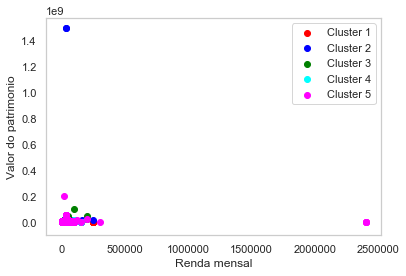

In [56]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

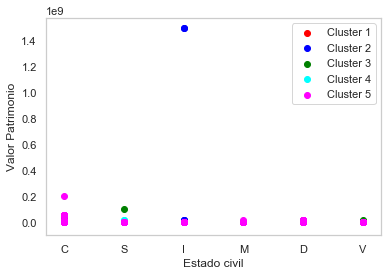

In [57]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].EstadoCivil, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Estado civil')
plt.ylabel('Valor Patrimonio')
plt.legend()
plt.show()

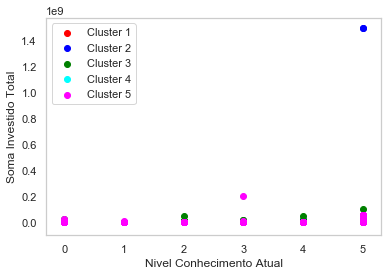

In [58]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].NivelConhecimentoAtual, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

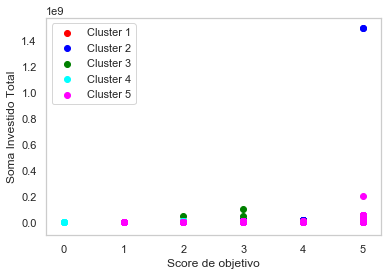

In [59]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].ScoreObjetivos, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Score de objetivo')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

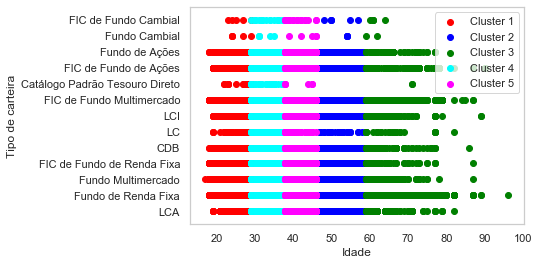

In [60]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].TipoCarteira__c, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].TipoCarteira__c, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].TipoCarteira__c, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].TipoCarteira__c, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].TipoCarteira__c, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Tipo de carteira')
plt.legend()
plt.show()

#### Predicao para clientes sem investimentos

In [61]:
cli_test = limpezaParaTreino(clientes_sem_investimento, ['Id', 'BillingCity', 'Soma_Investido_Total', 'ValorPatrimonio', 'RendaMensal', 'Soma_Investido_Total_Scaler'])

for coluna in cli_train.columns:
  if coluna.startswith('TipoCarteira__c'):
    cli_test[coluna] = 0

In [62]:
labelsTest = Kmean.predict(cli_test)

dfL = pd.DataFrame({'label': labelsTest},
                    index=clientes_sem_investimento.index)
result = pd.concat([clientes_sem_investimento, dfL], axis=1, join='inner')

In [63]:
result.groupby(['label'])['Idade'].count()

label
0    517
1    195
2     57
3    450
4    364
Name: Idade, dtype: int64

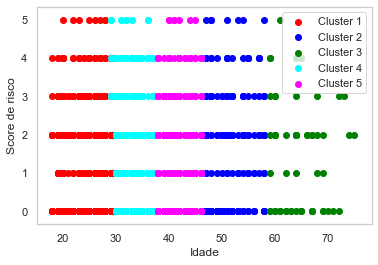

In [64]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ScoreRisco, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

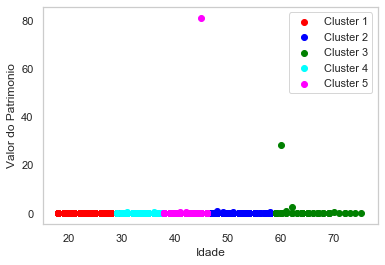

In [65]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio_Scaler, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

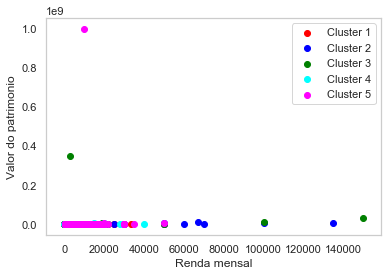

In [66]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

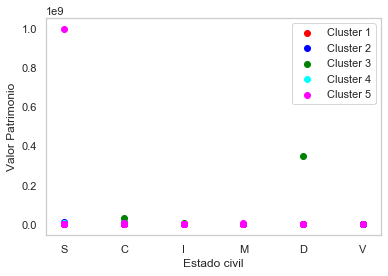

In [67]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].EstadoCivil, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Estado civil')
plt.ylabel('Valor Patrimonio')
plt.legend()
plt.show()

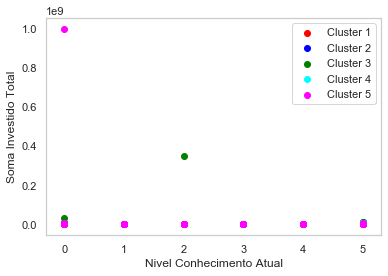

In [68]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].NivelConhecimentoAtual, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

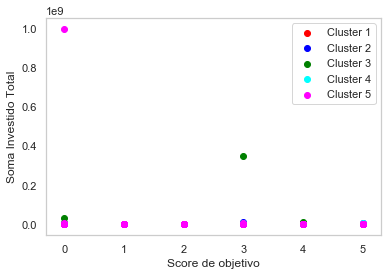

In [69]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].ScoreObjetivos, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.xlabel('Score de objetivo')
plt.ylabel('Soma Investido Total')
plt.legend()
plt.show()

### Analise com 7 cluster

In [70]:
Kmean = KMeans(n_clusters=7)
Kmean.fit(cli_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### dados de treino - clientes com investimentos

In [71]:
dfL = pd.DataFrame({'label': Kmean.labels_}, index=clientes_com_investimento.index)
result = pd.concat([clientes_com_investimento, dfL], axis=1, join='inner')

In [72]:
result.groupby(['label'])['Idade'].count()

label
0    6249
1    8378
2    1426
3    4421
4    6137
5    3397
6    6336
Name: Idade, dtype: int64

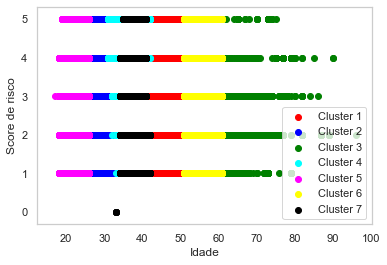

In [73]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ScoreRisco, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ScoreRisco, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ScoreRisco, c = 'black', label = 'Cluster 7')

plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

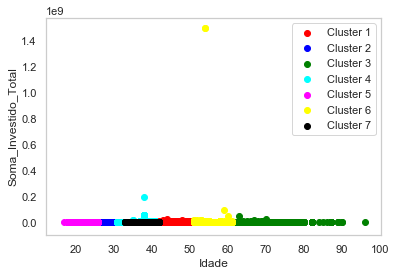

In [74]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Idade')
plt.ylabel('Soma_Investido_Total')
plt.legend()
plt.show()

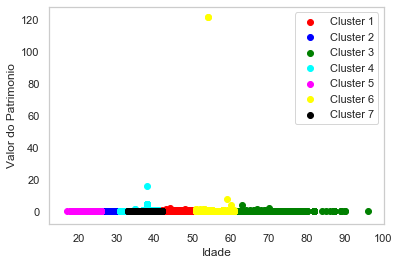

In [75]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio_Scaler, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ValorPatrimonio_Scaler, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ValorPatrimonio_Scaler, c = 'black', label = 'Cluster 7')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

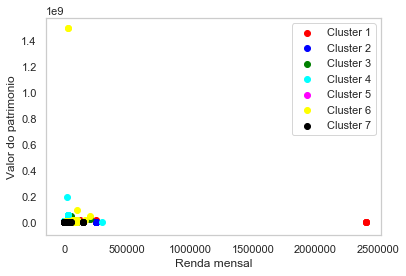

In [76]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].RendaMensal, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].RendaMensal, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

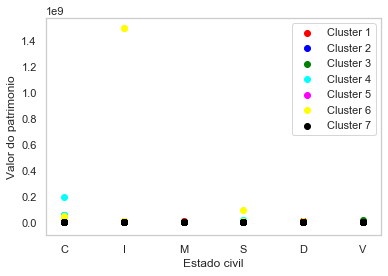

In [77]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].EstadoCivil, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].EstadoCivil, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].EstadoCivil, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Estado civil')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

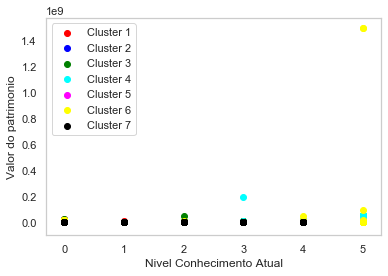

In [78]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].NivelConhecimentoAtual, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].NivelConhecimentoAtual, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].NivelConhecimentoAtual, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

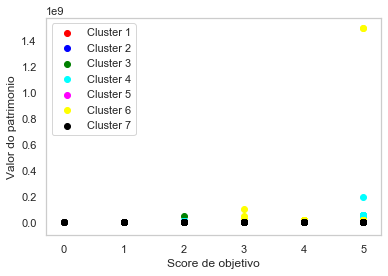

In [79]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].ScoreObjetivos, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].ScoreObjetivos, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].ScoreObjetivos, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Score de objetivo')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

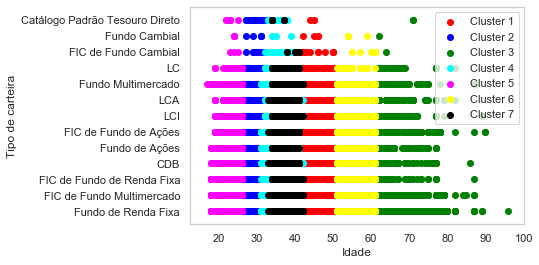

In [80]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].TipoCarteira__c, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].TipoCarteira__c, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].TipoCarteira__c, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].TipoCarteira__c, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].TipoCarteira__c, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].TipoCarteira__c, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].TipoCarteira__c, c = 'black', label = 'Cluster 7')
plt.xlabel('Idade')
plt.ylabel('Tipo de carteira')
plt.legend()
plt.show()

#### Predicao - clientes sem investimentos

In [81]:
cli_test = limpezaParaTreino(clientes_sem_investimento, ['Id', 'BillingCity', 'Soma_Investido_Total', 'ValorPatrimonio', 'RendaMensal', 'Soma_Investido_Total_Scaler'])

for coluna in cli_train.columns:
  if coluna.startswith('TipoCarteira__c'):
    cli_test[coluna] = 0

In [82]:
labelsTest = Kmean.predict(cli_test)

dfL = pd.DataFrame({'label': labelsTest},
                    index=clientes_sem_investimento.index)
result = pd.concat([clientes_sem_investimento, dfL], axis=1, join='inner')

In [83]:
result.groupby(['label'])['Idade'].count()

label
0    243
1    374
2     40
3     42
4    368
5    137
6    379
Name: Idade, dtype: int64

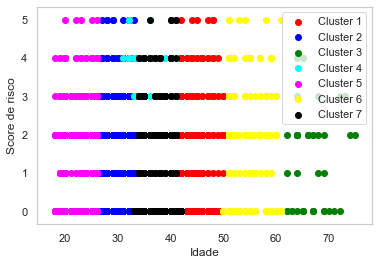

In [84]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ScoreRisco, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ScoreRisco, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ScoreRisco, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ScoreRisco, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ScoreRisco, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ScoreRisco, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ScoreRisco, c = 'black', label = 'Cluster 7')

plt.xlabel('Idade')
plt.ylabel('Score de risco')
plt.legend()
plt.show()

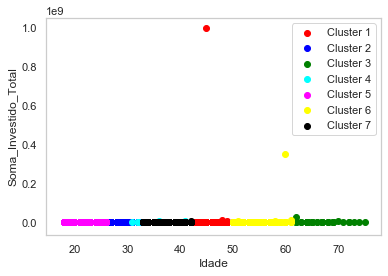

In [85]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Idade')
plt.ylabel('Soma_Investido_Total')
plt.legend()
plt.show()

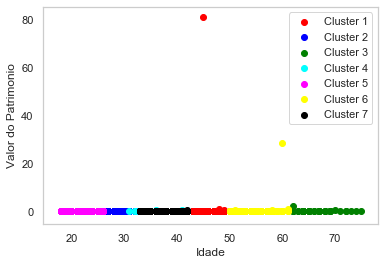

In [86]:
plt.scatter(result[result['label'] == 0].Idade, result[result['label'] == 0].ValorPatrimonio_Scaler, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].Idade, result[result['label'] == 1].ValorPatrimonio_Scaler, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].Idade, result[result['label'] == 2].ValorPatrimonio_Scaler, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].Idade, result[result['label'] == 3].ValorPatrimonio_Scaler, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].Idade, result[result['label'] == 4].ValorPatrimonio_Scaler, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].Idade, result[result['label'] == 5].ValorPatrimonio_Scaler, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].Idade, result[result['label'] == 6].ValorPatrimonio_Scaler, c = 'black', label = 'Cluster 7')
plt.xlabel('Idade')
plt.ylabel('Valor do Patrimonio')
plt.legend()
plt.show()

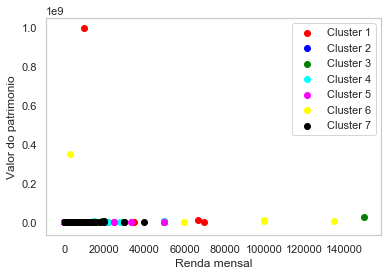

In [87]:
plt.scatter(result[result['label'] == 0].RendaMensal, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].RendaMensal, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].RendaMensal, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].RendaMensal, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].RendaMensal, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].RendaMensal, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].RendaMensal, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Renda mensal')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

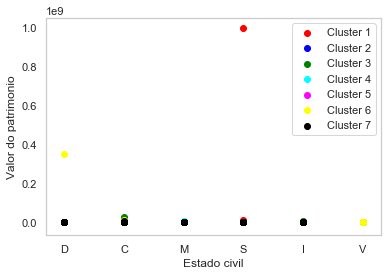

In [88]:
plt.scatter(result[result['label'] == 0].EstadoCivil, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].EstadoCivil, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].EstadoCivil, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].EstadoCivil, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].EstadoCivil, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].EstadoCivil, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].EstadoCivil, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Estado civil')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

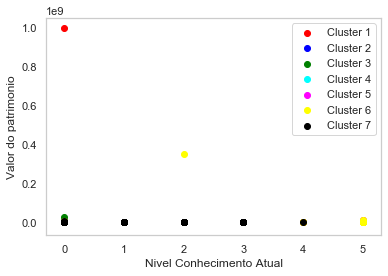

In [89]:
plt.scatter(result[result['label'] == 0].NivelConhecimentoAtual, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].NivelConhecimentoAtual, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].NivelConhecimentoAtual, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].NivelConhecimentoAtual, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].NivelConhecimentoAtual, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].NivelConhecimentoAtual, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].NivelConhecimentoAtual, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Nivel Conhecimento Atual')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

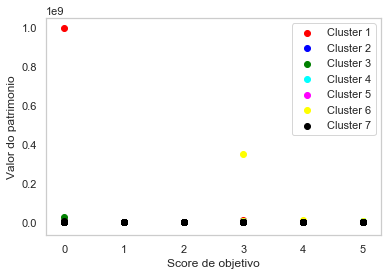

In [90]:
plt.scatter(result[result['label'] == 0].ScoreObjetivos, result[result['label'] == 0].ValorPatrimonio, c = 'red', label = 'Cluster 1')
plt.scatter(result[result['label'] == 1].ScoreObjetivos, result[result['label'] == 1].ValorPatrimonio, c = 'blue', label = 'Cluster 2')
plt.scatter(result[result['label'] == 2].ScoreObjetivos, result[result['label'] == 2].ValorPatrimonio, c = 'green', label = 'Cluster 3')
plt.scatter(result[result['label'] == 3].ScoreObjetivos, result[result['label'] == 3].ValorPatrimonio, c = 'cyan', label = 'Cluster 4')
plt.scatter(result[result['label'] == 4].ScoreObjetivos, result[result['label'] == 4].ValorPatrimonio, c = 'magenta', label = 'Cluster 5')
plt.scatter(result[result['label'] == 5].ScoreObjetivos, result[result['label'] == 5].ValorPatrimonio, c = 'yellow', label = 'Cluster 6')
plt.scatter(result[result['label'] == 6].ScoreObjetivos, result[result['label'] == 6].ValorPatrimonio, c = 'black', label = 'Cluster 7')
plt.xlabel('Score de objetivo')
plt.ylabel('Valor do patrimonio')
plt.legend()
plt.show()

#### Salvar modelo

In [91]:
Kmean = KMeans(n_clusters=7)

Kmean.fit(cli_train)

pickle.dump(Kmean, open('../repository/model_cli_kmean.sav', 'wb'))

In [92]:
dfL = pd.DataFrame({'label': Kmean.labels_}, index=clientes_com_investimento.index)
alldata = pd.concat([clientes_com_investimento, dfL], axis=1, join='inner')

usu_prod = pd.read_csv("../repository/usu_prod_group.csv",sep=',')

alldata = pd.merge(usu_prod, alldata, on='Id')
groupByClient = alldata
groupByClient

,Id,ProdutoId,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,Ind_Guardado,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,Soma_Investido_Total,Sao_Paulo,Rio,Brasilia,TipoCarteira__c,Soma_Investido_Total_Scaler,ValorPatrimonio_Scaler,RendaMensal_Scaler,label
0,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe9yBilu2JVQh2nFTHN...,a0W6A000009GZdgUAG,30,M,Aracruz,1,1,2,1300.0,6000.0,1,2,2,1,30.0,False,False,False,Fundo de Renda Fixa,-0.302138,-0.049448,-0.256733,6
1,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,a0W6A000009GZdgUAG,25,S,Teresina,1,1,2,500.0,0.0,2,3,3,1,3090.7,False,False,False,Fundo de Renda Fixa,-0.275618,-0.049935,-0.285720,0
2,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,a0W6A000009GZdgUAG,25,S,Teresina,1,1,2,500.0,0.0,2,3,3,1,3090.7,False,False,False,Fundo de Renda Fixa,-0.275618,-0.049935,-0.285720,0
3,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,a0W6A000009GZdgUAG,25,S,Teresina,1,1,2,500.0,0.0,2,3,3,1,3090.7,False,False,False,Fundo de Renda Fixa,-0.275618,-0.049935,-0.285720,0
4,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,a0W6A000009GZdgUAG,25,S,Teresina,1,1,2,500.0,0.0,2,3,3,1,3090.7,False,False,False,Fundo de Renda Fixa,-0.275618,-0.049935,-0.285720,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296529,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeJ/SmDXRVoa03nJIT4...,a0W6A000008HwdFUAS,59,S,Araguari,2,2,2,7000.0,100000.0,4,1,2,3,3500.0,False,False,False,Fundo de Renda Fixa,-0.272071,-0.041824,-0.050200,4
296530,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeJ/SmDXRVoa03nJIT4...,a0W6A000009ai38UAA,59,S,Araguari,2,2,2,7000.0,100000.0,4,1,2,3,3500.0,False,False,False,CDB,-0.272071,-0.041824,-0.050200,4
296531,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeJ/SmDXRVoa03nJIT4...,a0W6A000009ai38UAA,59,S,Araguari,2,2,2,7000.0,100000.0,4,1,2,3,3500.0,False,False,False,Fundo de Renda Fixa,-0.272071,-0.041824,-0.050200,4
296532,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeJ/SmDXRVoa03nJIT4...,a0W6A000009ai38UAA,59,S,Araguari,2,2,2,7000.0,100000.0,4,1,2,3,3500.0,False,False,False,Fundo de Renda Fixa,-0.272071,-0.041824,-0.050200,4


In [93]:
groupByClient.to_csv('../repository/clientes_groups.csv')